In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
from timeit import timeit
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score, f1_score
from sklearn.model_selection import cross_val_score, train_test_split
from joblib import dump, load
from imblearn.under_sampling import RandomUnderSampler

In [2]:
from compiledataset import load_dataset, compile_dataset

PATH = "/home/hampus/miun/master_thesis/Datasets"

datasets = {}

dataset: pd.DataFrame = load_dataset(PATH + "/ORNL", "data_a.csv")
dataset["remarks"] = "No DLC available"
datasets["ROAD"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Survival", "data.csv")
# dataset["remarks"] = "-"
# datasets["Survival"] = dataset.to_dict("records")

# dataset: pd.DataFrame = load_dataset(PATH + "/Hisingen", "data.csv")
# dataset["remarks"] = "-"
# datasets["Hisingen"] = dataset.to_dict("records")


df = compile_dataset(datasets)
df.drop(columns=["d0", "d1", "d2", "d3", "d4", "d5", "d6", "d7", "data", "data_dec", "ID", "DLC", "t"], inplace=True, errors="ignore")

dataset = None # Release memory, as it isn't used for now
datasets = None

display(df)

,dcs,dt,dt_ID,dt_data,dt_runs,name,class,dataset,type,Label
0,0.061541,4.073523e-04,0.009999,0.382671,0.008899,correlated_signal_attack_1,unknown,ROAD,none,0
1,0.061541,1.019955e-03,0.009999,0.382671,0.008899,correlated_signal_attack_1,unknown,ROAD,none,0
2,0.061541,1.072884e-06,0.019998,0.382671,0.008899,correlated_signal_attack_1,unknown,ROAD,none,0
3,0.061541,2.026558e-06,0.009999,0.382671,0.008899,correlated_signal_attack_1,unknown,ROAD,none,0
4,0.061541,9.536743e-07,0.009998,0.382671,0.008899,correlated_signal_attack_1,unknown,ROAD,none,0
...,...,...,...,...,...,...,...,...,...,...
3266459,0.000000,1.192093e-06,0.050870,0.050870,0.014857,reverse_light_on_attack_3_masquerade,unknown,ROAD,none,0
3266460,0.000000,9.977818e-04,0.019898,0.019898,0.008704,reverse_light_on_attack_3_masquerade,unknown,ROAD,none,0
3266461,0.000000,2.145767e-06,0.010723,0.010723,0.010723,reverse_light_on_attack_3_masquerade,unknown,ROAD,none,0
3266462,0.109375,9.536743e-07,0.025351,0.699479,0.025351,reverse_light_on_attack_3_masquerade,unknown,ROAD,none,0


In [3]:
df = df.loc[df["type"] != "masq"]
# df = df.loc[(df["type"] == "fuzz") | (df["type"] == "none")]

In [4]:
col = "dcs"
v_r         = df.loc[(df["Label"] == 0) & (df["dataset"] == "ROAD"), col]
v_sonata    = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Sonata"), col]
v_soul      = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Soul"), col]
v_spark     = df.loc[(df["Label"] == 0) & (df["dataset"] == "Survival") & (df["class"] == "Spark"), col]

print(v_r.mean(), v_r.std())
print(v_sonata.mean(), v_sonata.std())
print(v_soul.mean(), v_soul.std())
print(v_spark.mean(), v_spark.std())

0.038454200279409 0.05707752562405587
nan nan
nan nan
nan nan


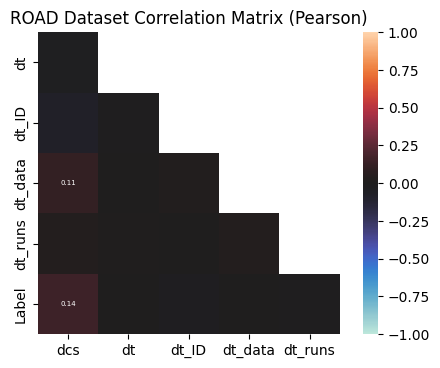

In [5]:
from plot_tools import plot_correlation_matrix

plot_correlation_matrix(df.drop(columns=["dataset", "type", "name", "class" "ID", "DLC", "t"], errors="ignore"))

In [6]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# for cl in ["unknown", "Sonata", "Soul", "Spark"]:
#     for col in ["dt", "dt_ID", "dt_ID_data", "dcs"]:
#         scaler = StandardScaler().fit(df.loc[(df["Label"] == 0) & (df["class"] == cl), df.columns == col])
#         df.loc[df["class"] == cl, col] = scaler.transform(df.loc[df["class"] == cl, df.columns == col])

for col in ["dt", "dt_ID", "dt_data", "dt_runs", "dcs"]:
    scaler = RobustScaler().fit(df.loc[df["Label"] == 0, df.columns == col])
    df.loc[:, df.columns ==col] = scaler.transform(df.loc[:, df.columns == col])

display(df)

,dcs,dt,dt_ID,dt_data,dt_runs,name,class,dataset,type,Label
0,0.734662,0.405378,-0.907152,0.940915,0.472387,correlated_signal_attack_1,unknown,ROAD,none,0
1,0.734662,1.017878,-0.907180,0.940915,0.472387,correlated_signal_attack_1,unknown,ROAD,none,0
2,0.734662,-0.000834,0.012653,0.940915,0.472387,correlated_signal_attack_1,unknown,ROAD,none,0
3,0.734662,0.000119,-0.907153,0.940915,0.472387,correlated_signal_attack_1,unknown,ROAD,none,0
4,0.734662,-0.000954,-0.907209,0.940915,0.472387,correlated_signal_attack_1,unknown,ROAD,none,0
...,...,...,...,...,...,...,...,...,...,...
3266459,-0.250000,-0.000715,2.852762,-0.163849,1.209995,reverse_light_on_attack_3_masquerade,unknown,ROAD,none,0
3266460,-0.250000,0.995709,0.003487,-0.266974,0.448180,reverse_light_on_attack_3_masquerade,unknown,ROAD,none,0
3266461,-0.250000,0.000238,-0.840546,-0.297523,0.698173,reverse_light_on_attack_3_masquerade,unknown,ROAD,none,0
3266462,1.500000,-0.000954,0.505143,1.995759,2.509254,reverse_light_on_attack_3_masquerade,unknown,ROAD,none,0


In [7]:
# Stratify on the sub-dataset
X_train = df.drop(columns="Label")
y_train = df["Label"]

df = None # Release memory

# Split dataset into training and test data, stratify by the type of attack
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.3, random_state=0, shuffle=True, stratify=X_train["name"])

In [8]:
rus = RandomUnderSampler(random_state=0)
X_train, y_train = rus.fit_resample(X_train, y_train)
X_test, y_test = rus.fit_resample(X_test, y_test)
bintr = np.bincount(y_train)
binte = np.bincount(y_test)
print(f"Labels\t\tTraining\tTesting\nNormal\t\t{bintr[0]}\t\t{binte[0]}\nAttack\t\t{bintr[1]}\t\t{binte[1]}")

Labels		Training	Testing
Normal		22276		9527
Attack		22276		9527


In [9]:
# train_index = X_train.loc[X_train["dataset"] == "Survival"].index
# test_index = X_test.loc[X_test["dataset"] == "ROAD"].index
# train_index = X_train.loc[(X_train["dataset"] == "Survival") & (X_train["name"] == "Fuzzy_dataset_SONATA")].index
# test_index = X_test.loc[(X_test["dataset"] == "ROAD") & (X_test["name"] == "fuzzing_attack_1")].index

# X_train = X_train.loc[train_index]
# y_train = y_train.loc[train_index]

# X_test = X_test.loc[test_index]
# y_test = y_test.loc[test_index]

In [10]:
name_train = X_train["name"]
name_test = X_test["name"]
X_train.drop(columns=["type", "dataset", "name", "class"], inplace=True)
X_test.drop(columns=["type", "dataset", "name", "class"], inplace=True)

In [11]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=20, random_state=0, max_leaf_nodes=300, max_features="log2", warm_start=True)
clf.fit(X_train, y_train)

RandomForestClassifier(max_features='log2', max_leaf_nodes=300, n_estimators=20,
                       random_state=0, warm_start=True)

In [12]:
scores = cross_val_score(clf, X_train, y_train, scoring='f1', cv=10, n_jobs=-1)
print("Training F1: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std()))

pred = clf.predict(X_test)

f1_scores = f1_score(y_test, pred, average='weighted')
print("Testing F1:  %0.4f(+/- %0.4f)" % (f1_scores.mean(), f1_scores.std()))

kappa_scores = cohen_kappa_score(y_test, pred)
print("Kappa score:  %0.4f(+/- %0.4f)" % (kappa_scores.mean(), kappa_scores.std()))

Training F1: 0.9995 (+/- 0.0004)
Testing F1:  0.9995(+/- 0.0000)
Kappa score:  0.9991(+/- 0.0000)


Plot test data predictions

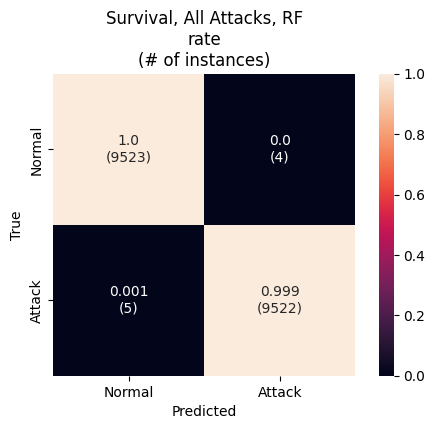

In [13]:
from plot_tools import plot_confusion_matrix

plot_confusion_matrix(y_test, pred, "Survival, All Attacks, RF\nrate\n(# of instances)")

Plot train data predictions

In [14]:
# pred_train = clf.predict(X_train)

# plot_confusion_matrix(y_train, pred_train, "Survival, All Attacks, RF\nrate\n(# of instances)")

Add trees trained on the FPs and FNs

In [15]:
# clf.set_params(n_estimators=30) # Add another 20 trees for the FN and FPs
# clf.fit(X_train.loc[y_train != pred_train], y_train.loc[y_train != pred_train])

Plot test data predictions again

In [16]:
# pred_test = clf.predict(X_test)

# plot_confusion_matrix(y_test, pred_test, "Survival, All Attacks, RF\nrate\n(# of instances)")

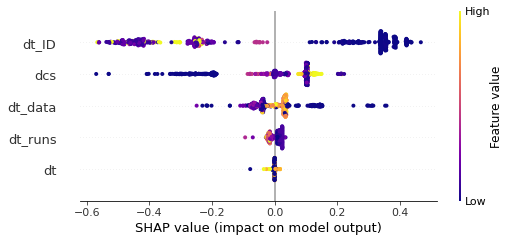

In [19]:
import shap
from shap_tools import *


exp = shap.TreeExplainer(clf)

# # Make sure that the ingested SHAP model (a TreeEnsemble object) makes the
# # same predictions as the original model
# assert np.abs(exp.model.predict(X_test_sample) - clf.predict_proba(X_test_sample)).max() < 1e-4

# # Make sure the SHAP values sum up to the model output (this is the local accuracy property)
# assert np.abs(exp.expected_value + exp.shap_values(X_test_sample).sum(1) - clf.predict_proba(X_test_sample)).max() < 1e-4


# print(len(X_train.loc[y_train != pred]))
# print(len(X_train.loc[y_train == pred]))
# shap_false = get_explanation(exp, X_train.loc[y_train != pred])
# shap_FP = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 1)])
# shap_FN = get_explanation(exp, X_train.loc[(y_train != pred) & (pred == 0)])
# shap_true = get_explanation(exp, X_train.loc[y_train == pred])
# shap_TP = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 1)])
# shap_TN = get_explanation(exp, X_train.loc[(y_train == pred) & (pred == 0)])

# shap_TP_fuzz = get_explanation(exp, X_test.loc[(y_train == pred) & (pred == 1) & (name_test == "Fuzzy_dataset_SONATA")])

shap_all = get_explanation(exp, X_train)

plot_beeswarm(shap_all)

# plot_beeswarm(shap_all)
# shap.plots.waterfall(shap_TP_fuzz[0])

# shap_values = explainer(X_test.sample(1000, random_state=0))
# shap_values = shap.Explanation(shap_values[:, :, 1], feature_names=X_test.columns)

# shap.summary_plot(shap_values)


# shap.waterfall_plot(shap.Explanation(values=shap_values[int("which_class")][row], 
#                                          base_values=explainer.expected_value[int(which_class)], 
#                                          data=X_test.iloc[row],  # added this line
#                                          feature_names=X_test.columns.tolist()))
# shap.force_plot(explainer.expected_value[1], shap_values[1], features=X_test[:1], feature_names=X_test.columns)

# shap.plots.scatter(shap_values[:,"ones_w"])
# shap.summary_plot(shap_values[1], X_test.columns)

# plt.show()